In [1]:
import matplotlib.pyplot as plt
import os

In [2]:
os.environ["PATH"] = os.pathsep + os.path.join("..", "mlp_solver")

In [3]:
!ipopt -v

Ipopt 3.12.13 (Linux x86_64), ASL(20211109)



In [4]:
import pandas as pd
import numpy as np
#from tqdm.notebook import tqdm
from tqdm import tqdm

In [5]:
from dsl import spec, SpecTracker
from dsl.grammar import (
    create_variable as V,
    Expectation as E,
    Specification
)
from dsl.tests.database.database import Database

In [6]:
import logging

level = logging.CRITICAL
logger = logging.getLogger()
logger.setLevel(level)
for handler in logger.handlers:
    handler.setLevel(level)

In [7]:
%matplotlib inline

In [8]:
data_fp = './dsl/tests/datasets/data/compas/compas-scores-two-years.csv'

In [9]:
data = pd.read_csv(data_fp)

In [10]:
data.head(n=2)

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1


In [11]:
data.v_decile_score.describe()

count    7214.000000
mean        3.691849
std         2.510148
min         1.000000
25%         1.000000
50%         3.000000
75%         5.000000
max        10.000000
Name: v_decile_score, dtype: float64

In [12]:
len(data)

7214

In [13]:
def did_or_didnt_recid_in_2_years(df):
    select_attributes = ["id", "age", "c_charge_degree", "race",
                         "age_cat", "score_text", "sex",
                         "priors_count", "days_b_screening_arrest", "decile_score",
                         "is_recid", "two_year_recid", "c_jail_in", "c_jail_out"]
    view = df[select_attributes].copy()
    view = view[(view.days_b_screening_arrest <= 30) & (view.days_b_screening_arrest >= -30)]
    view = view[view.is_recid != -1]
    view = view[view.c_charge_degree != "O"]
    view = view[view.score_text != 'N/A']
    return view

In [14]:
did_or_didnt_recid_in_2_years(data).columns

Index(['id', 'age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex',
       'priors_count', 'days_b_screening_arrest', 'decile_score', 'is_recid',
       'two_year_recid', 'c_jail_in', 'c_jail_out'],
      dtype='object')

In [15]:
database = Database(data)
threshold_l = 1.1
threshold_r = 0.9
decile_threshold = 3.0
delta_threshold = 0.1

In [16]:
def get_spec():
    return E(V("decile_score" ) > decile_threshold, given=(V("two_year_recid") == 0) & (V("race") == "African-American")) / \
    E(V("decile_score" ) > decile_threshold, given=(V("two_year_recid") == 0) & (V("race") == "Caucasian"))  < threshold_l

def get_inverse_spec():
    return E(V("decile_score") > decile_threshold, given=(V("two_year_recid") == 0) & (V("race") == "Caucasian")) / \
        E(V("decile_score") > decile_threshold, given=(V("two_year_recid") == 0) & (V("race") == "African-American")) > threshold_r

def get_spec_or():
     return (E(V("decile_score") > decile_threshold,given=(V("two_year_recid") == 0) & (V("race") == "African-American")) / \
        E(V("decile_score") > decile_threshold,given=(V("two_year_recid") == 0) & (V("race") == "Caucasian"))  < threshold_l) | \
        (E(V("decile_score") > decile_threshold,given=(V("two_year_recid") == 0) & (V("race") == "Caucasian")) / \
        E(V("decile_score") > decile_threshold,given=(V("two_year_recid") == 0) & (V("race") == "African-American")) > threshold_r)

In [17]:
def get_values_for_term(spec_hist, term):
    xs, values = [], []
    for x, dict_vals in spec_hist:
        xs.append(x)
        values.append(dict_vals.get(term.id))
    return xs, values

In [18]:
def conf_plot(xs, ys, cs, hline):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(xs, ys, color="b")
    ax.plot(xs, ys + cs, color="r", linestyle="dashed")
    ax.plot(xs, ys - cs, color="r", linestyle="dashed")
    ax.fill_between(xs, ys-cs, ys+cs, color="b", alpha=0.1)
    ax.hlines(hline, xmin=np.min(xs), xmax=np.max(xs), color="g")
    ax.set_ylim(-1.5, 1.5)
    return fig, ax


## Test Materialized view

In [19]:
my_spec = get_spec()
database.create_materialized_view(
    "two_year_recid_results",
    query=did_or_didnt_recid_in_2_years,
    specification=my_spec,
    observation_key="id",
    progress_bar=tqdm,
    spec_args={"include_confidence": True, "delta": delta_threshold, "optimization_frequency": 5, "our_approach": True},
)



6172it [01:05, 94.73it/s] 


In [20]:
spec_history = database.views["two_year_recid_results"].observer.spec_val_history

In [21]:
xs, values = get_values_for_term(spec_history, my_spec)
deltas = [val.delta for val in values]

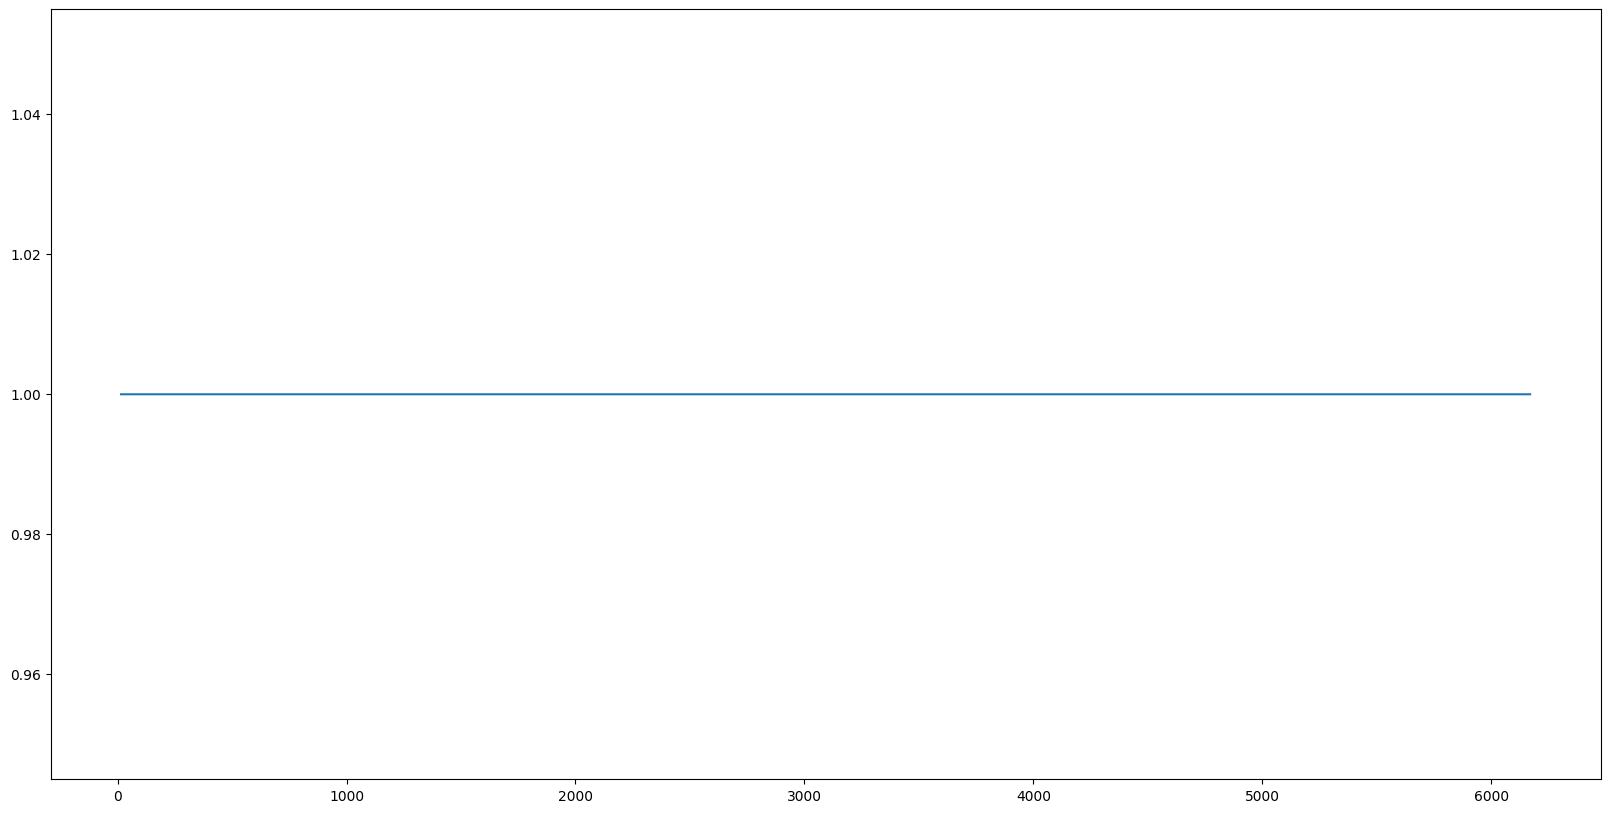

In [22]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(xs, deltas)

In [23]:
database.views["two_year_recid_results"].observer.best_achieved

1.0

## Inverse Spec

In [24]:
inv_spec = get_inverse_spec()
view_name = "two_year_recid_results_inv"
database.create_materialized_view(
    view_name,
    query=did_or_didnt_recid_in_2_years,
    specification=inv_spec,
    observation_key="id",
    progress_bar=tqdm,
    spec_args={"include_confidence": True, "delta": delta_threshold, "optimization_frequency": 5, "our_approach": True}
)

6172it [00:55, 111.91it/s]


In [25]:
inv_spec_history = database.views[view_name].observer.spec_val_history

In [26]:
xs, values = get_values_for_term(inv_spec_history, inv_spec)
deltas = [val.delta for val in values]

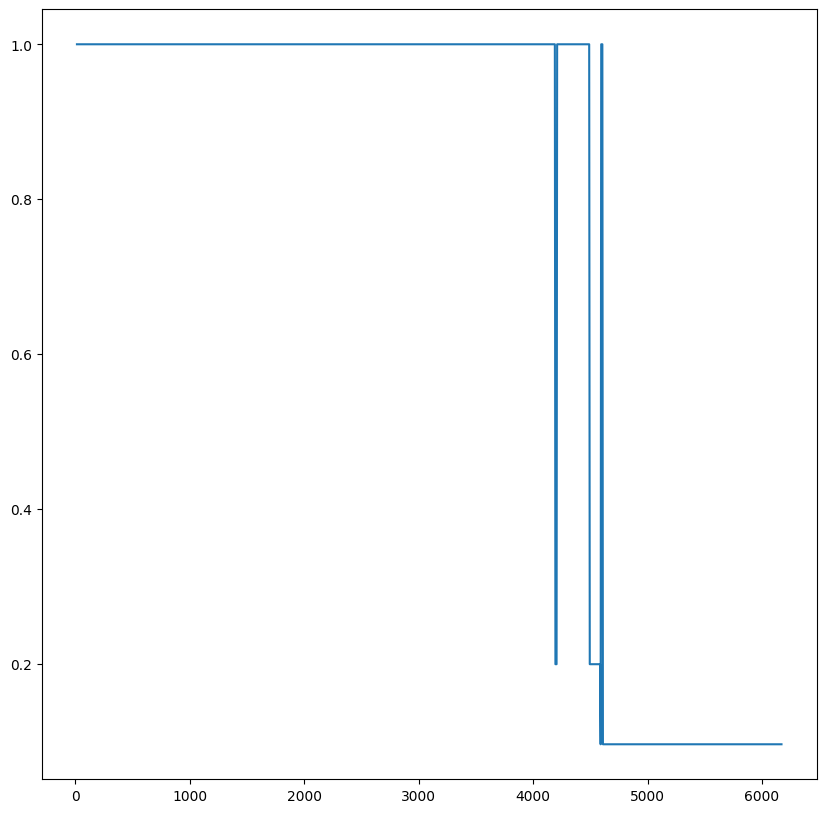

In [27]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(xs, deltas)

In [28]:
xs, values = get_values_for_term(inv_spec_history, inv_spec.left_child.expectation_term)
ys, cs = zip(*[(value.val, value.epsilon) for value in values])

xs, ys, cs = (np.array(t) for t in (xs, ys, cs))


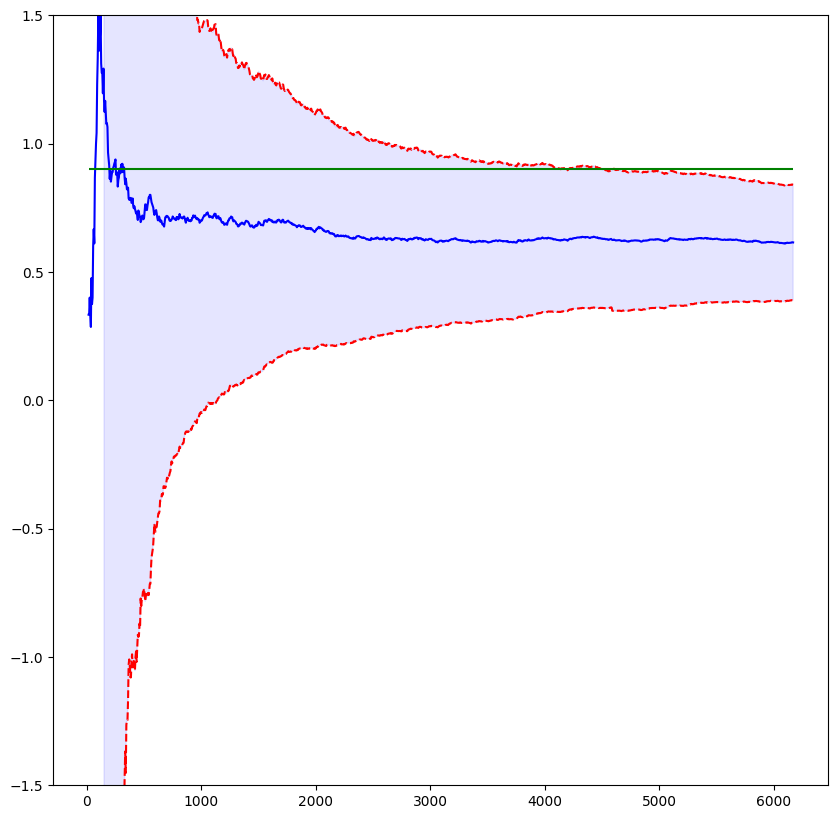

In [29]:
fig, ax = conf_plot(xs, ys, cs, inv_spec.left_child.threshold.val)

In [30]:
inv_spec_v = get_inverse_spec()
view_name_v = "two_year_recid_results_inv_v"
database.create_materialized_view(
    view_name_v,
    query=did_or_didnt_recid_in_2_years,
    specification=inv_spec_v,
    observation_key="id",
    progress_bar=tqdm,
    spec_args={"include_confidence": True, "delta": delta_threshold, "optimization_frequency": 5, "our_approach": False}
)

6172it [00:27, 223.14it/s]


In [31]:
inv_spec_history_v = database.views[view_name_v].observer.spec_val_history

In [32]:
xs_v, values_v = get_values_for_term(inv_spec_history_v, inv_spec_v)
deltas_v = [val.delta for val in values_v]

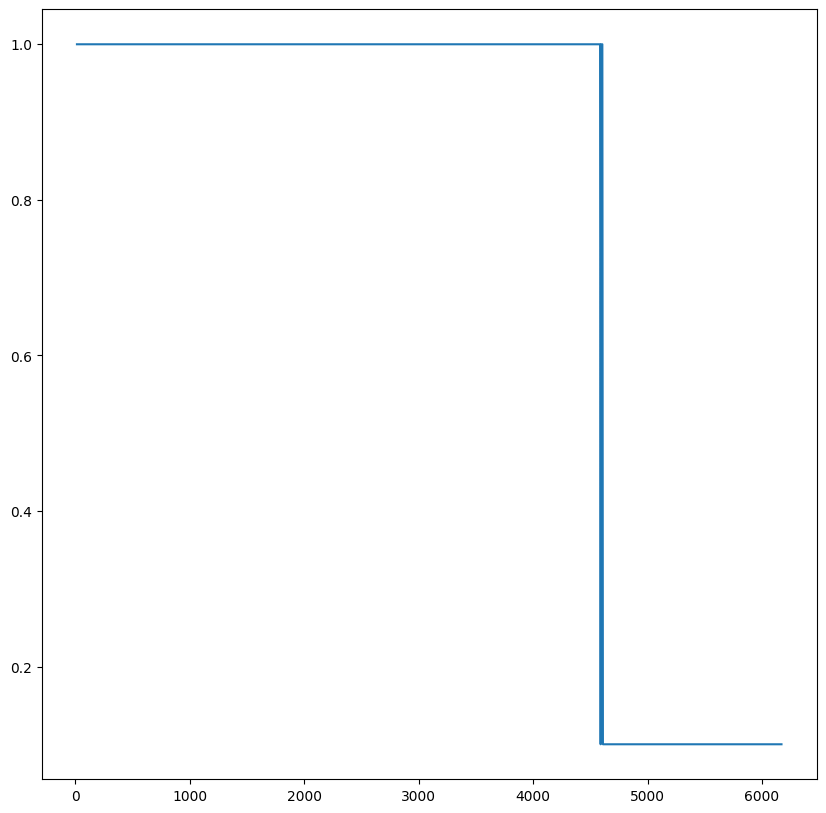

In [33]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(xs_v, deltas_v)

In [34]:
database.views[view_name].observer.optimization_achieved_step, database.views[view_name_v].observer.optimization_achieved_step

(4590, 4590)

***

In [35]:
xs_v, values_v = get_values_for_term(inv_spec_history_v, inv_spec_v.left_child.expectation_term)
ys_v, cs_v = zip(*[(value_v.val, value_v.epsilon) for value_v in values_v])

xs_v, ys_v, cs_v = (np.array(t) for t in (xs_v, ys_v, cs_v))

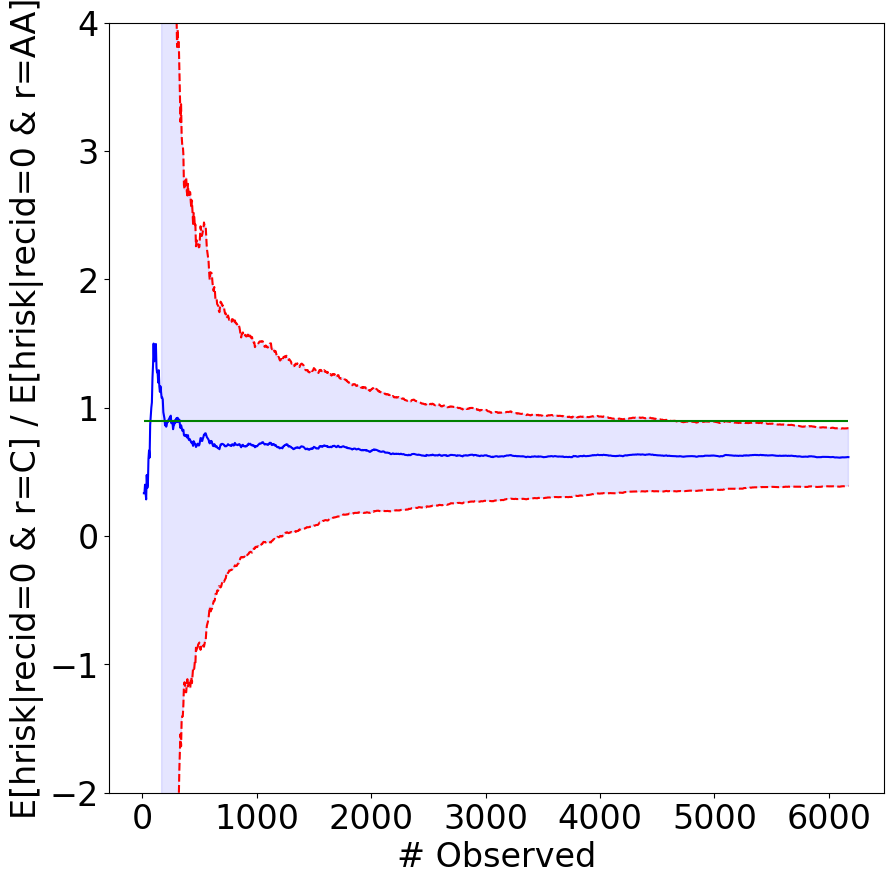

In [38]:
fig, ax = conf_plot(xs_v, ys_v, cs_v, inv_spec_v.left_child.threshold.val)
ax.set_ylim(-2, 4)
ax.set_xlabel("# Observed", fontsize=24)
ax.set_ylabel("E[hrisk|recid=0 & r=C] / E[hrisk|recid=0 & r=AA]", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=24)

In [39]:
fig.savefig("plots/compas-propublica-et.png")

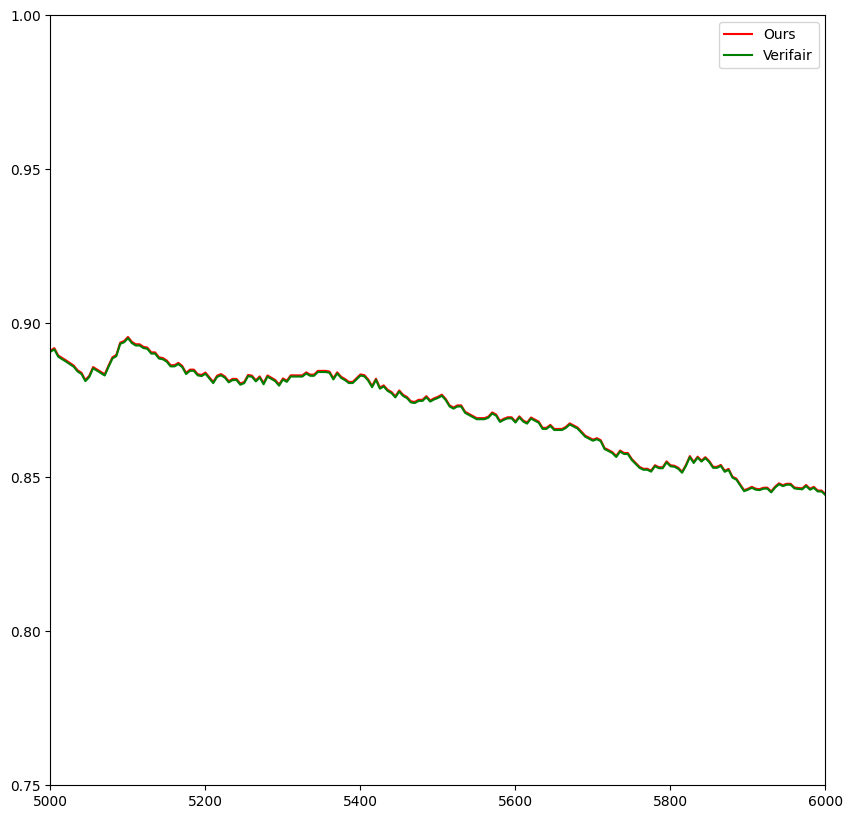

In [40]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(xs, ys + cs, color="r", label="Ours")
ax.plot(xs_v, ys_v + cs_v, color="g", label="Verifair")
ax.set_ylim((0.75, 1))
ax.set_xlim(5000, 6000)
ax.legend()

In [41]:
xs_l, values_l = get_values_for_term(inv_spec_history, inv_spec.left_child.expectation_term.left_child)
xs_r, values_r = get_values_for_term(inv_spec_history, inv_spec.left_child.expectation_term.right_child)

In [42]:
deltas_l = [value.delta for value in values_l]
deltas_r = [value.delta for value in values_r]

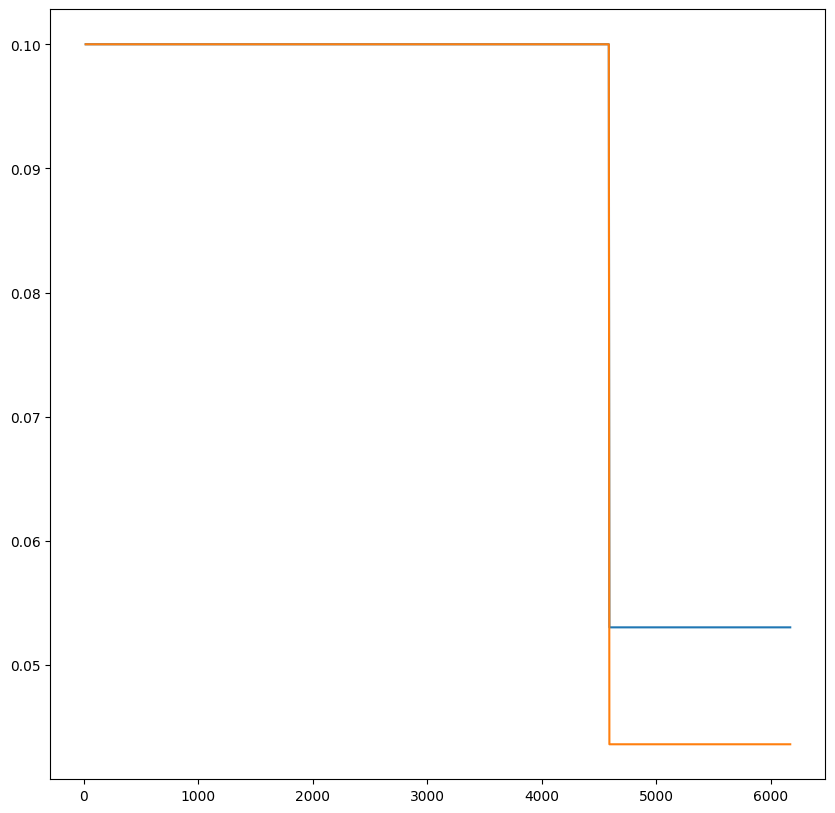

In [43]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(xs_l, deltas_l)
ax.plot(xs_r, deltas_r)

## Northpointe

In [44]:
def get_spec():
    return E(V("two_year_recid") == 0, given=((V("decile_score" ) > decile_threshold) & (V("race") == "Caucasian"))) / \
    E(V("two_year_recid") == 0, given=((V("decile_score" ) > decile_threshold) & (V("race") == "African-American")))  > threshold_l


In [45]:
inv_spec = get_spec()
view_name = "two_year_recid_results_inv"
database.create_materialized_view(
    view_name,
    query=did_or_didnt_recid_in_2_years,
    specification=inv_spec,
    observation_key="id",
    progress_bar=tqdm,
    spec_args={"include_confidence": True, "delta": delta_threshold, "optimization_frequency": 5, "our_approach": True}
)

6172it [01:09, 88.41it/s] 


In [46]:
inv_spec_history = database.views[view_name].observer.spec_val_history

In [47]:
xs, values = get_values_for_term(inv_spec_history, inv_spec)
deltas = [val.delta for val in values]

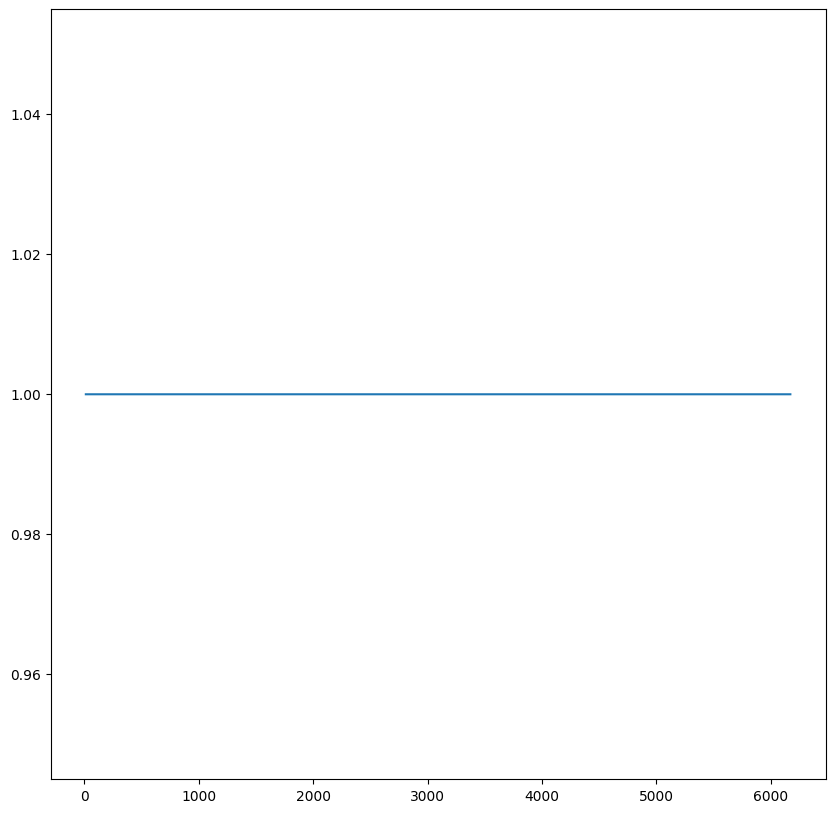

In [48]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(xs, deltas)

In [49]:
xs, values = get_values_for_term(inv_spec_history, inv_spec.left_child.expectation_term)
ys, cs = zip(*[(value.val, value.epsilon) for value in values])

xs, ys, cs = (np.array(t) for t in (xs, ys, cs))


(E[two_year_recid = 0 | decile_score > 3.0 & race = Caucasian] / E[two_year_recid = 0 | decile_score > 3.0 & race = African-American] > 1.1)


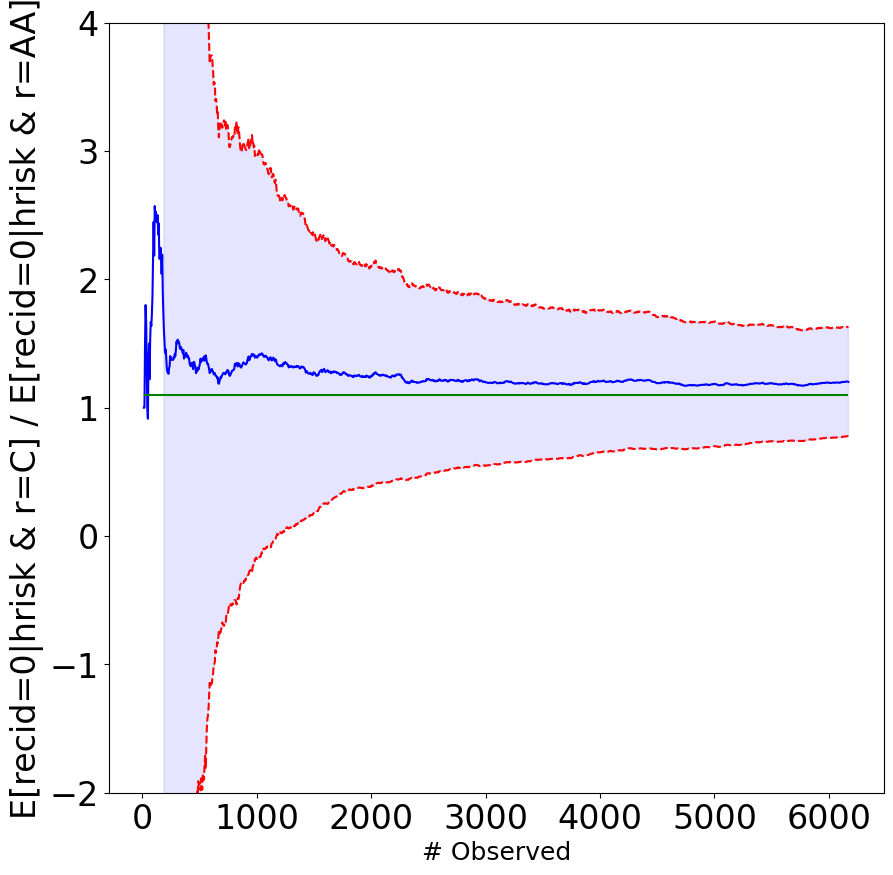

In [50]:
fig, ax = conf_plot(xs, ys, cs, inv_spec.left_child.threshold.val)
ax.set_ylim(-2, 4)
ax.set_xlabel("# Observed", fontsize=18)
ax.set_ylabel("E[recid=0|hrisk & r=C] / E[recid=0|hrisk & r=AA]", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=24)
print(inv_spec.left_child)

In [51]:
fig.savefig("plots/compas-northpointe-et.png")